In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

!pip install metric-learn

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import ITML_Supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 691.1 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import h5py

houston18_file = h5py.File('/content/drive/MyDrive/proje/Houston18.mat', 'r')
houston18_gt_file = h5py.File('/content/drive/MyDrive/proje/Houston18_7gt.mat', 'r')

data = np.array(houston18_file['ori_data'])
gt = np.array(houston18_gt_file['map'])


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


data = np.transpose(data, (1, 2, 0))

data=applyPCA(data)

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df['class'] = gt.ravel()

X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values



In [4]:


acc_list = []

kf = KFold(n_splits=5, shuffle=True,random_state=42)

itml = ITML_Supervised()
knn = KNeighborsClassifier(n_neighbors=5)

f_index = 1
for train_index, test_index in kf.split(X):
    print(f"Fold {f_index} -> Train: {len(train_index)}, Test: {len(test_index)}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    itml.fit(X_train, y_train)
    knn.fit(itml.transform(X_train), y_train)


    itml_acc = knn.score(itml.transform(X_test), y_test)
    print('itml accuracy  {}'.format(itml_acc))

    acc_list.append(itml_acc)

    f_index += 1

print("Ortalaması Başarı:", np.mean(acc_list))
print("Standart sapma:",np.std(acc_list) )

Fold 1 -> Train: 42560, Test: 10640
itml accuracy  0.875093984962406
Fold 2 -> Train: 42560, Test: 10640
itml accuracy  0.8705827067669173
Fold 3 -> Train: 42560, Test: 10640
itml accuracy  0.8807330827067669
Fold 4 -> Train: 42560, Test: 10640
itml accuracy  0.8875
Fold 5 -> Train: 42560, Test: 10640
itml accuracy  0.8825187969924813
Ortalaması Başarı: 0.8792857142857142
Standart sapma: 0.005887870982334672


In [5]:
import joblib

joblib.dump(itml, 'itml_houston_model.pkl')
joblib.dump(knn,'itml_houston_knn_model.pkl')

itml_loaded = joblib.load('itml_houston_model.pkl')
knn_loaded =joblib.load('itml_houston_knn_model.pkl')

itml_data=itml_loaded.transform(X)
pred=knn_loaded.predict(itml_data)

In [6]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

print("accuracy:",accuracy_score(pred,y))
print("cohen kappa:", cohen_kappa_score(pred,y))
print("f1 score:",f1_score(pred,y,average='macro'))

accuracy: 0.9072744360902255
cohen kappa: 0.8446531879651029
f1 score: 0.8880245876872045


In [7]:
gt_2 = gt.copy()
gt_2=gt_2.reshape(-1)


i = 0
j=0
while(i<(gt.shape[0]*gt.shape[1])):
      if(gt_2[i] != 0):
          gt_2[i]=pred[j]
          j += 1
      i += 1

In [8]:
gt_2=gt_2.reshape(data.shape[0],-1)

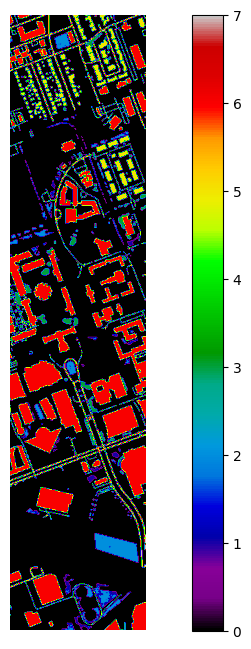

In [9]:
def plot_gt(data):
  fig = plt.figure(figsize=(12, 8))
  plt.imshow(data,cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_gt(gt)

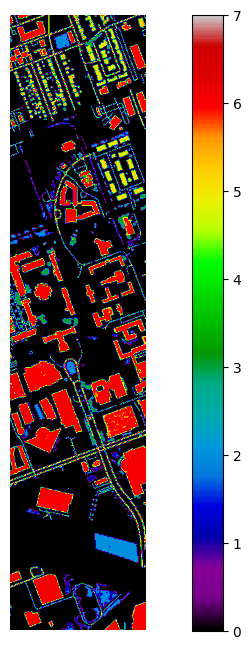

In [10]:
plot_gt(gt_2)